# FMLIKH Model: Creep Response

## Protocol-Specific Context (Multi-Mode)

**FMLIKH creep** shows **distributed delay times** from hierarchical structure:

1. **Fast modes break first**: Early strain accumulation
2. **Medium modes break next**: Intermediate acceleration
3. **Slow modes break last**: Final yielding avalanche (if stress sufficient)

**Why this matters**: Single-mode FIKH predicts one delay time $t_d$. FMLIKH with N=3 can show **stepped creep acceleration** as successive structural levels yield. This captures experimental creep curves with multiple inflection points.

> **Physical insight**: Each mode has yield threshold $\sigma_{y,i} = \sigma_{y0} + \Delta\sigma_y \cdot w_i \cdot \lambda_i$. Under constant stress, fast modes (weak contribution) break first, then medium, then slow (strong contribution) — producing staged yielding.

> **Handbook:** See [FMLIKH Creep](../../docs/source/models/fikh/fmlikh.rst) for multi-mode delay time distributions.

## Learning Objectives

1. Simulate FMLIKH creep with N=3 modes
2. Observe staged yielding: fast → medium → slow modes
3. Analyze mode-by-mode structural breakdown
4. Compare FMLIKH vs single-mode FIKH creep
5. Understand delay time distribution $t_{d,i} \sim (\Delta\sigma_i)^{-1/\alpha_i}$

## Prerequisites

- NB07: FMLIKH flow curve
- NB04: FIKH creep (single-mode baseline)

**Estimated Time:** 4-6 minutes (fast), 15-20 minutes (full)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fmlikh_param_names,
    load_ml_ikh_creep,
    print_convergence_summary,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# ============================================================
# FAST_MODE Configuration
# ============================================================
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print("FAST_MODE: reduced samples for quick validation")
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    print("FULL mode: complete Bayesian inference")
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

FAST_MODE: reduced samples for quick validation


## 2. Load Data

In [3]:
STRESS_PAIR = 0
time_data, gamma_dot_data, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=STRESS_PAIR)

strain_data = np.cumsum(gamma_dot_data[:-1] * np.diff(time_data))
strain_data = np.insert(strain_data, 0, 0.0)

print(f"Stress: {sigma_final} Pa")
print(f"Data points: {len(time_data)}")

Stress: 5.0 Pa
Data points: 70


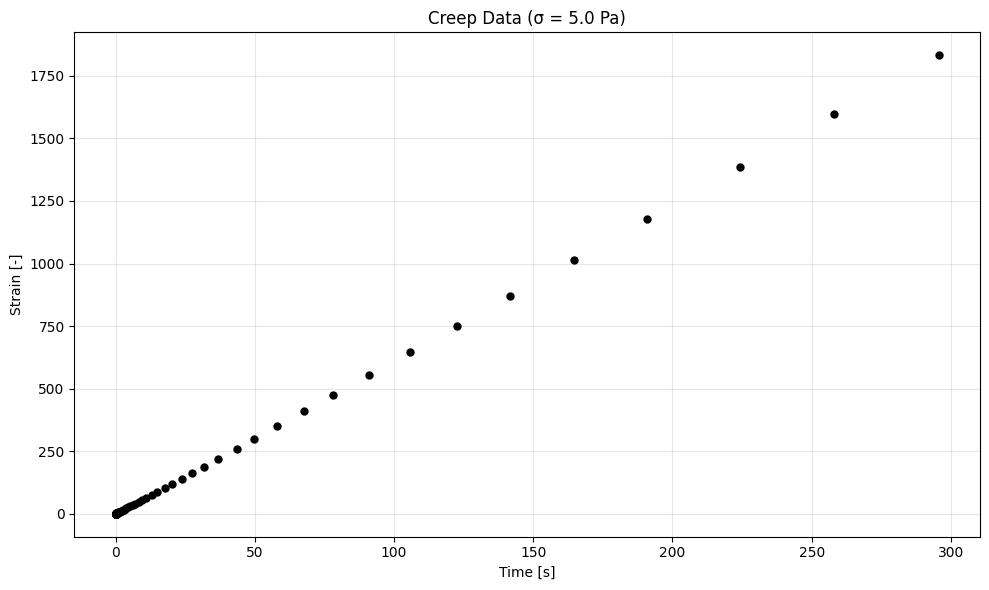

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, strain_data, "ko", markersize=5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Strain [-]")
ax.set_title(f"Creep Data (σ = {sigma_final} Pa)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. NLSQ Fitting

In [5]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

# For creep: we fit to strain vs time, but model needs stress history
# Create constant stress array
stress_data = np.full_like(time_data, sigma_final)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
print(f"NLSQ time: {time.time() - t0:.2f} s")

stress_pred = model.predict(time_data, test_mode="startup", strain=strain_data)
metrics = compute_fit_quality(stress_data, stress_pred)
print(f"R² = {metrics['R2']:.6f}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 561, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ time: 0.33 s
R² = 0.000000


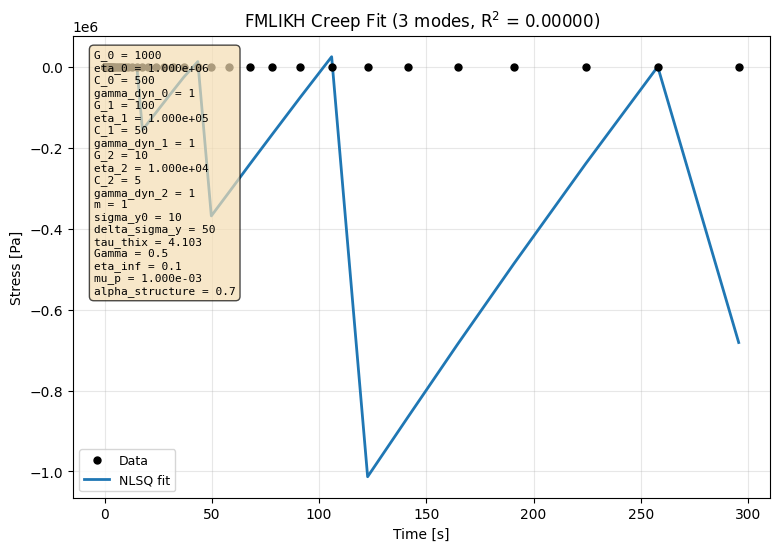

In [6]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)

fig, ax = plot_nlsq_fit(
    time_data, stress_data, model, test_mode="startup",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"FMLIKH Creep Fit ({N_MODES} modes, R$^2$ = {metrics['R2']:.5f})",
    x_pred=time_data,
    strain=strain_data,
)
display(fig)
plt.close(fig)

## 4. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model.parameters.get_value(n) for n in param_names if n in model.parameters}

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, data points={len(time_data)}")

t0 = time.time()
result = model.fit_bayesian(
    time_data, stress_data, test_mode="startup", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
  FAST_MODE=True, data points=70


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:02<06:23,  2.57s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  27%|██▋       | 40/150 [00:02<00:05, 20.87it/s, 3 steps of size 5.81e-12. acc. prob=0.62]

sample:  42%|████▏     | 63/150 [00:06<00:09,  9.48it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  51%|█████     | 76/150 [00:09<00:10,  7.24it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  56%|█████▌    | 84/150 [00:11<00:10,  6.46it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  60%|██████    | 90/150 [00:12<00:10,  5.99it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  63%|██████▎   | 94/150 [00:13<00:09,  5.64it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  65%|██████▍   | 97/150 [00:14<00:09,  5.44it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  66%|██████▌   | 99/150 [00:14<00:09,  5.31it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  67%|██████▋   | 101/150 [00:15<00:09,  5.16it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  69%|██████▊   | 103/150 [00:15<00:09,  5.02it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  69%|██████▉   | 104/150 [00:16<00:09,  4.94it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  70%|███████   | 105/150 [00:16<00:09,  4.86it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  71%|███████   | 106/150 [00:16<00:09,  4.78it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  71%|███████▏  | 107/150 [00:16<00:09,  4.71it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  72%|███████▏  | 108/150 [00:16<00:09,  4.63it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  73%|███████▎  | 109/150 [00:17<00:08,  4.56it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  73%|███████▎  | 110/150 [00:17<00:08,  4.52it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  74%|███████▍  | 111/150 [00:17<00:08,  4.48it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  75%|███████▍  | 112/150 [00:17<00:08,  4.45it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  75%|███████▌  | 113/150 [00:18<00:08,  4.43it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  76%|███████▌  | 114/150 [00:18<00:08,  4.42it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  77%|███████▋  | 115/150 [00:18<00:07,  4.42it/s, 255 steps of size 2.63e-16. acc. prob=0.82]

sample:  77%|███████▋  | 116/150 [00:18<00:07,  4.43it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  78%|███████▊  | 117/150 [00:19<00:07,  4.39it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  79%|███████▊  | 118/150 [00:19<00:07,  4.15it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  79%|███████▉  | 119/150 [00:19<00:07,  4.23it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  80%|████████  | 120/150 [00:19<00:07,  4.27it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  81%|████████  | 121/150 [00:19<00:06,  4.28it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  81%|████████▏ | 122/150 [00:20<00:06,  4.30it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  82%|████████▏ | 123/150 [00:20<00:06,  4.33it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  83%|████████▎ | 124/150 [00:20<00:05,  4.36it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  83%|████████▎ | 125/150 [00:20<00:05,  4.38it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  84%|████████▍ | 126/150 [00:21<00:05,  4.38it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  85%|████████▍ | 127/150 [00:21<00:05,  4.39it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  85%|████████▌ | 128/150 [00:21<00:05,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  86%|████████▌ | 129/150 [00:21<00:04,  4.41it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  87%|████████▋ | 130/150 [00:22<00:04,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  87%|████████▋ | 131/150 [00:22<00:04,  4.41it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  88%|████████▊ | 132/150 [00:22<00:04,  4.42it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  89%|████████▊ | 133/150 [00:22<00:03,  4.41it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  89%|████████▉ | 134/150 [00:22<00:03,  4.34it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  90%|█████████ | 135/150 [00:23<00:03,  4.34it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  91%|█████████ | 136/150 [00:23<00:03,  4.35it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  91%|█████████▏| 137/150 [00:23<00:02,  4.37it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  92%|█████████▏| 138/150 [00:23<00:02,  4.38it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  93%|█████████▎| 139/150 [00:24<00:02,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  93%|█████████▎| 140/150 [00:24<00:02,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.84]

sample:  94%|█████████▍| 141/150 [00:24<00:02,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  95%|█████████▍| 142/150 [00:24<00:01,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  95%|█████████▌| 143/150 [00:24<00:01,  4.38it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  96%|█████████▌| 144/150 [00:25<00:01,  4.39it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  97%|█████████▋| 145/150 [00:25<00:01,  4.39it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  97%|█████████▋| 146/150 [00:25<00:00,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  98%|█████████▊| 147/150 [00:25<00:00,  4.39it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  99%|█████████▊| 148/150 [00:26<00:00,  4.40it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample:  99%|█████████▉| 149/150 [00:26<00:00,  4.41it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample: 100%|██████████| 150/150 [00:26<00:00,  4.41it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

sample: 100%|██████████| 150/150 [00:26<00:00,  5.64it/s, 255 steps of size 2.63e-16. acc. prob=0.83]

Bayesian time: 30.3 s


In [8]:
key_params = ["G_0", "alpha_structure", "sigma_y0"]
print_convergence_summary(result, key_params)

print("\n### Convergence Targets")
print("| Metric | Target | Interpretation |")
print("|--------|--------|----------------|")
print("| **R-hat** | < 1.01 | Chain convergence |")
print("| **ESS** | > 400 | Effective samples |")
print("| **Divergences** | < 1% | NUTS quality |")

display_arviz_diagnostics(result, key_params, fast_mode=FAST_MODE)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    0.9899         1     CHECK
alpha_structure    0.9899         1     CHECK
       sigma_y0    0.9899         1     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Convergence Targets
| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence |
| **ESS** | > 400 | Effective samples |
| **Divergences** | < 1% | NUTS quality |


### Convergence Diagnostics

**Convergence Targets:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence |
| **ESS** | > 400 | Effective samples |
| **Divergences** | < 1% | NUTS quality |

## 5. Save Results

In [9]:
save_fikh_results(model, result, "fmlikh", "creep", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/creep/
  nlsq_params_creep.json: 20 parameters
  posterior_creep.json: 100 draws


## Key Takeaways

1. **FMLIKH creep shows staged yielding** as modes break sequentially
2. **Fast modes yield first; slow modes yield last**
3. **Multiple inflection points** in creep curve from mode distribution
4. **Delay times distributed** via $t_{d,i} \sim (\Delta\sigma_i)^{-1/\alpha_i}$
5. **Hierarchical structure produces rich creep dynamics**
6. **Residual analysis** validates staged yielding transitions

---

## Further Reading

- **[FMLIKH Creep Dynamics](../../docs/source/models/fikh/fmlikh.rst#distributed-fractional-kinetics)**: Mode-by-mode breakdown analysis
- **[Hierarchical Materials](../../docs/source/models/fikh/fmlikh.rst#hierarchical-microstructure-interpretation)**: Relating modes to structural levels

### Key References

1. Wei, Y. et al. (2018). "A multimode structural kinetics constitutive equation." *J. Rheol.*, 62(1), 321-342.
2. Geri, M. et al. (2017). "Thermokinematic memory and thixotropic elasto-viscoplasticity." *J. Rheol.*, 61(3), 427-454.

### Next Steps

**Next**: NB11 (SAOS) — broadened Cole-Cole depression from multi-mode spectra